In [1]:
import numpy as np
from tensorflow import keras
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import seaborn as sns

In [63]:
data=pd.read_csv('E:/SEM-1/Smart Energy/Project/India/India Renewable data.csv',parse_dates=['Time'])

In [67]:
#dataframe=data.loc[data['Date'].notna() == True]
#dataframe=dataframe.replace(to_replace ="Not Available",value = 0)
#df = dataframe[0:500] # first 120 months as training set
#test_data = dataframe[500:]
#df['Date']=pd.to_datetime(df['Date'],format='%d-%m-%Y')
#df=df[(df['Date']<'2020-01-01')]
df=data.loc[data['Time'].notna() == True]
df=df.replace(to_replace ="Not Available",value = 0)

In [68]:
train_dates=pd.to_datetime(df['Time'],format='%d-%m-%Y')

In [69]:
cols=list(df)[1:30]

In [70]:
df_for_training=df[cols].astype('float')

In [71]:
scaler=StandardScaler()

In [72]:
scaler=scaler.fit(df_for_training)

In [73]:
df_for_training_scaled=scaler.transform(df_for_training)

In [74]:
n_future=1
n_past=20

In [75]:
#Defining training(trainX) and Prediction(trainY) Attribites
trainX=[]
trainY=[]

In [76]:
for i in range(n_past,len(df_for_training_scaled)-n_future+1):
    trainX.append(df_for_training_scaled[i-n_past:i,0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i+n_future-1:i+n_future,4])

In [77]:
trainX, trainY=np.array(trainX),np.array(trainY)

In [78]:
print('trainX shape=={}.'.format(trainX.shape))
print('trainY shape=={}.'.format(trainY.shape))

trainX shape==(64, 20, 15).
trainY shape==(64, 1).


In [79]:
model=Sequential()

In [80]:
model.add(LSTM(256,activation='relu',input_shape=(trainX.shape[1],trainX.shape[2]),return_sequences=True))

In [81]:
model.add(LSTM(64,activation='relu',return_sequences=False))

In [82]:
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

In [83]:
model.compile(optimizer='adam',loss='mean_squared_error')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 20, 256)           278528    
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                82176     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 360,769
Trainable params: 360,769
Non-trainable params: 0
_________________________________________________________________


In [84]:
history=model.fit(trainX,trainY,epochs=80,batch_size=60,validation_split=0.1,verbose=1)

Epoch 1/80
1/1 [==============================] - 3s 3s/step - loss: 0.9318 - val_loss: 1.5852
Epoch 2/80
1/1 [==============================] - 0s 64ms/step - loss: 0.8717 - val_loss: 1.5136
Epoch 3/80
1/1 [==============================] - 0s 65ms/step - loss: 0.8694 - val_loss: 1.4205
Epoch 4/80
1/1 [==============================] - 0s 63ms/step - loss: 0.8599 - val_loss: 1.3318
Epoch 5/80
1/1 [==============================] - 0s 65ms/step - loss: 0.8000 - val_loss: 1.2303
Epoch 6/80
1/1 [==============================] - 0s 65ms/step - loss: 0.7823 - val_loss: 1.1389
Epoch 7/80
1/1 [==============================] - 0s 62ms/step - loss: 0.7257 - val_loss: 1.0596
Epoch 8/80
1/1 [==============================] - 0s 66ms/step - loss: 0.6505 - val_loss: 0.9591
Epoch 9/80
1/1 [==============================] - 0s 65ms/step - loss: 0.6487 - val_loss: 0.8708
Epoch 10/80
1/1 [==============================] - 0s 65ms/step - loss: 0.5786 - val_loss: 0.7072
Epoch 11/80
1/1 [==============

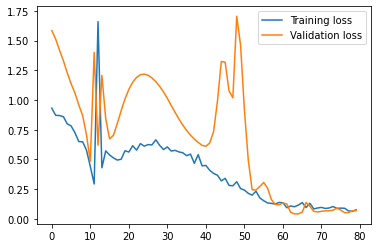

In [85]:
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'],label='Validation loss')
plt.legend()

In [86]:
n_days_for_prediction=13

In [87]:
predict_period_dates = pd.date_range(list(train_dates)[-1], periods=n_days_for_prediction, freq='MS').tolist()

In [88]:
forecast=model.predict(trainX[-n_days_for_prediction:])

In [89]:
forecast_copies=np.repeat(forecast,df_for_training.shape[1],axis=-1)

In [90]:
y_pred_future=scaler.inverse_transform(forecast_copies)[:,4]

In [91]:
forecast_dates=[]
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

In [94]:
df_forecast=pd.DataFrame({'Time':np.array(forecast_dates),'Hydroelectric Power Production':y_pred_future})

In [93]:
df_forecast['Time']=pd.to_datetime(df_forecast['Time'])
df_forecast

,Time,Hydroelectric Power Production
0,2021-02-01,8782.988281
1,2021-03-01,7853.648926
2,2021-04-01,7680.010742
3,2021-05-01,8285.608398
4,2021-06-01,10044.723633
5,2021-07-01,12471.512695
6,2021-08-01,15703.259766
7,2021-09-01,18944.042969
8,2021-10-01,20980.460938
9,2021-11-01,19878.013672


In [35]:
df_forecast['row_num'] = np.arange(len(df_forecast))
test_data['row_num'] = np.arange(len(test_data))
#final_dataset=df_forecast[['Date & Time','House_overall_predicted']].merge(original[['Date & Time','House_overall_Original']], on='Date & Time', how='left')
final_dataset=pd.merge(test_data,df_forecast,on='row_num')
df_forecast=df_forecast.drop('row_num',1)
test_data=test_data.drop('row_num',1)
final_dataset=final_dataset.drop('row_num',1).drop('Date_y',1)
final_dataset.rename(columns = {'Date_x' : 'Date'}, inplace = True)
final_dataset

NameError: name 'test_data' is not defined

C:\Users\bsaiv\anaconda3\envs\tf\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\bsaiv\anaconda3\envs\tf\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Date', ylabel='Hydroelectric Power Production_x'>

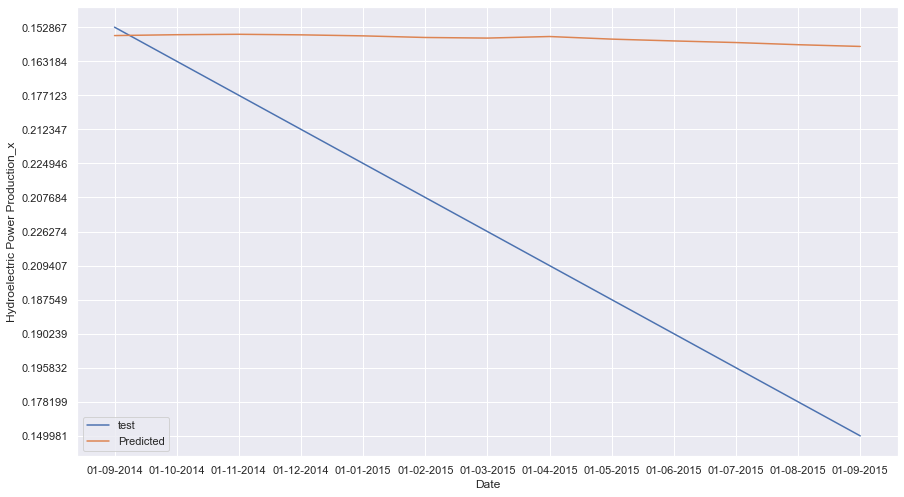

In [183]:
sns.set(rc={'figure.figsize':(14.7,8.27)})
sns.lineplot(final_dataset['Date'],final_dataset["Hydroelectric Power Production_x"],label='test')
sns.lineplot(final_dataset['Date'],final_dataset["Hydroelectric Power Production_y"],label='Predicted')